In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import keras

import random as rn

np.random.seed(42)
rn.seed(42)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)


from keras import backend as K

tf.set_random_seed(42)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

generate_data = False


x = np.load("data/x.npy")
y = np.load("data/y.npy")

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization

best_aucroc = 0

In [3]:
activations = ['relu', 'tanh', 'hard_sigmoid']
dropouts = [0.7, 0.8, 0.9]
num_total_layers = [2]
losses = ['binary_crossentropy']
val_sizes = [0.33]
last_layer_sizes = [100, 150, 200]
last_layer_drop_sizes = [0.15, 0.20, 0.3]


# activations = ['tanh']
# dropouts = [0.93, 0.3, 0.99]
# num_total_layers = [4]
# losses = ['categorical_hinge']
# val_sizes = [0.4]
# last_layer_sizes = [20]
# last_layer_drop_sizes = [0.15]

In [4]:
def get_correct_split(test_size_input):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size_input, random_state=42)
    return x_train, x_test, y_train, y_test

In [ ]:
def create_model(activation, dropout, num_total_layer, last_layer_size, last_layer_drop_size):
    model = Sequential()
    model.add(BatchNormalization(input_shape=(len(x_train[0]),)))
    model.add(Dense(300))
    model.add(Activation(activation))
    model.add(Dropout(dropout))
    
    num_layers_still_needed = num_total_layer - 2 # We manually create first and last
        
    step_size = int((300 - last_layer_size) / (num_layers_still_needed + 1))
        
    count = 300

    
    for i in range(num_layers_still_needed):
        
        count -= step_size

        model.add(Dense(count))
        model.add(BatchNormalization())
        model.add(Activation(activation))
        model.add(Dropout(dropout))

    model.add(Dense(last_layer_size))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dropout(last_layer_drop_size))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

In [ ]:
# model.summary()

In [ ]:
from keras.callbacks import Callback

class Stat_Collector (Callback):
    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

        self.aucrocs_train = []
        self.aucrocs_val = []

    def on_epoch_end(self, batch, logs=None):
        # Make aucroc prediction for training data
        y_pred_train = self.model.predict(x_train)
        y_pred_train = y_pred_train.flatten()
        self.aucrocs_train.append(roc_auc_score(y_train, y_pred_train))
        
        
        # Make aucroc prediction for validation data
        y_pred_val = self.model.predict(x_test)
        y_pred_val = y_pred_val.flatten()
        self.aucrocs_val.append(roc_auc_score(y_test, y_pred_val))

In [ ]:
def train_model(model, activation, dropout, num_total_layer, loss, val_size, last_layer_size, last_layer_drop_size, x_train, y_train, x_test, y_test):
    stat_collect = Stat_Collector(x_train, y_train, x_test, y_test)

    model.compile(loss=loss,optimizer='adam', metrics=['accuracy'])

    fit = model.fit(x_train, y_train, batch_size=32, nb_epoch=30, verbose=1, callbacks = [stat_collect])

    import matplotlib.pyplot as plt

    num_epoch = len(stat_collect.aucrocs_val)

    # Plot training & validation accuracy values
    plt.plot([x + 1 for x in range(num_epoch)], stat_collect.aucrocs_train, label="Train AUCROC")
    plt.plot([x + 1 for x in range(num_epoch)], stat_collect.aucrocs_val, label="Test AUCROC")

    plt.xlabel('Test AUCROC maximized at epoch = {} with AUCROC = {}'.format(np.argmax(stat_collect.aucrocs_val) + 1, stat_collect.aucrocs_val[np.argmax(stat_collect.aucrocs_val)]))
    plt.ylabel('AUCROC')
    plt.title('Epochs vs. AUCROC')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig("plots/activation:{}_dropout:{}_numlayer:{}_loss:{}_valsize:{}_lastlayersize:{}_lastlayerdrop:{}.png".format(activation, dropout, num_total_layer, loss, val_size, last_layer_size, last_layer_drop_size))
    plt.show()
    global best_aucroc
    if best_aucroc < stat_collect.aucrocs_val[np.argmax(stat_collect.aucrocs_val)]:
        best_aucroc = stat_collect.aucrocs_val[np.argmax(stat_collect.aucrocs_val)]
        with open("plots/best_plot.txt", "a+") as f:
            f.write("plots/activation:{}_dropout:{}_numlayer:{}_loss:{}_valsize:{}_lastlayersize:{}_lastlayerdrop:{} \n Performance: {}\n".format(activation, dropout, num_total_layer, loss, val_size, last_layer_size, last_layer_drop_size, stat_collect.aucrocs_val[np.argmax(stat_collect.aucrocs_val)]))


relu 0.7 2 binary_crossentropy 0.33 100 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 5s 114us/step - loss: 0.5233 - acc: 0.7477
Epoch 2/30
43326/43326 [==============================] - 4s 92us/step - loss: 0.4964 - acc: 0.7607
Epoch 3/30
43326/43326 [==============================] - 4s 93us/step - loss: 0.4886 - acc: 0.7677
Epoch 4/30
43326/43326 [==============================] - 4s 94us/step - loss: 0.4848 - acc: 0.7691
Epoch 5/30
43326/43326 [==============================] - 4s 96us/step - loss: 0.4830 - acc: 0.7717
Epoch 6/30
43326/43326 [==============================] - 4s 93us/step - loss: 0.4812 - acc: 0.7727
Epoch 7/30
43326/43326 [==============================] - 4s 97us/step - loss: 0.4795 - acc: 0.7721
Epoch 8/30
43326/43326 [==============================] - 4s 93us/step - loss: 0.4790 - acc: 0.7727
Epoch 9/30
43326/43326 [==============================] - 4s 102us/step - loss: 0.4770 - acc: 0.7732
Epoch 10/30
43326/43326 [==============================] - 4s 92us/step - loss: 0.4758 - acc: 0.77

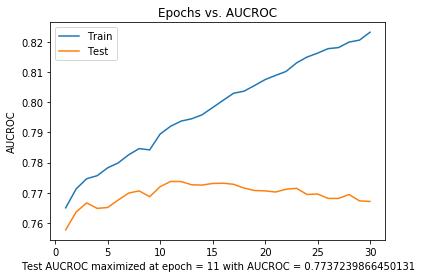

relu 0.7 2 binary_crossentropy 0.33 100 0.2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 5s 107us/step - loss: 0.5310 - acc: 0.7434
Epoch 2/30
43326/43326 [==============================] - 4s 93us/step - loss: 0.4951 - acc: 0.7623
Epoch 3/30
43326/43326 [==============================] - 4s 93us/step - loss: 0.4876 - acc: 0.7672
Epoch 4/30
43326/43326 [==============================] - 4s 96us/step - loss: 0.4865 - acc: 0.7677
Epoch 5/30
43326/43326 [==============================] - 4s 93us/step - loss: 0.4827 - acc: 0.7701
Epoch 6/30
43326/43326 [==============================] - 4s 94us/step - loss: 0.4817 - acc: 0.7713
Epoch 7/30
43326/43326 [==============================] - 4s 93us/step - loss: 0.4801 - acc: 0.7709
Epoch 8/30
43326/43326 [==============================] - 4s 93us/step - loss: 0.4781 - acc: 0.7723
Epoch 9/30
43326/43326 [==============================] - 4s 93us/step - loss: 0.4782 - acc: 0.7727
Epoch 10/30
43326/43326 [==============================] - 4s 94us/step - loss: 0.4758 - acc: 0.774

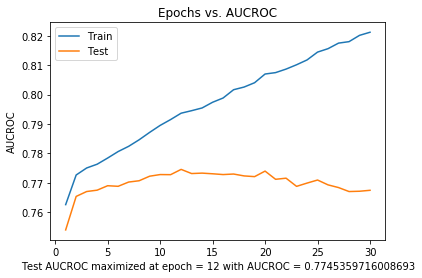

relu 0.7 2 binary_crossentropy 0.33 100 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 5s 113us/step - loss: 0.5316 - acc: 0.7414
Epoch 2/30
43326/43326 [==============================] - 4s 97us/step - loss: 0.4964 - acc: 0.7623
Epoch 3/30
43326/43326 [==============================] - 4s 95us/step - loss: 0.4885 - acc: 0.7640
Epoch 4/30
43326/43326 [==============================] - 4s 100us/step - loss: 0.4867 - acc: 0.7683
Epoch 5/30
43326/43326 [==============================] - 4s 99us/step - loss: 0.4845 - acc: 0.7674
Epoch 6/30
43326/43326 [==============================] - 4s 94us/step - loss: 0.4825 - acc: 0.7710
Epoch 7/30
43326/43326 [==============================] - 4s 98us/step - loss: 0.4818 - acc: 0.7698
Epoch 8/30
43326/43326 [==============================] - 4s 95us/step - loss: 0.4792 - acc: 0.7735
Epoch 9/30
43326/43326 [==============================] - 4s 95us/step - loss: 0.4776 - acc: 0.7733
Epoch 10/30
43326/43326 [==============================] - 4s 95us/step - loss: 0.4756 - acc: 0.77

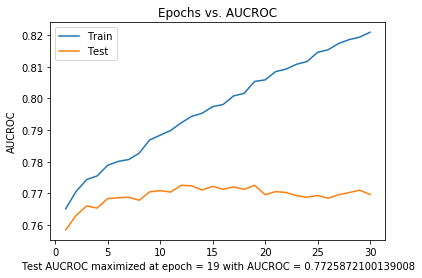

relu 0.7 2 binary_crossentropy 0.33 150 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 5s 119us/step - loss: 0.5294 - acc: 0.7417
Epoch 2/30
43326/43326 [==============================] - 4s 101us/step - loss: 0.4947 - acc: 0.7625
Epoch 3/30
43326/43326 [==============================] - 4s 103us/step - loss: 0.4895 - acc: 0.7640
Epoch 4/30
43326/43326 [==============================] - 4s 103us/step - loss: 0.4872 - acc: 0.7681
Epoch 5/30
43326/43326 [==============================] - 4s 103us/step - loss: 0.4831 - acc: 0.7710
Epoch 6/30
43326/43326 [==============================] - 4s 102us/step - loss: 0.4810 - acc: 0.7722
Epoch 7/30
43326/43326 [==============================] - 4s 102us/step - loss: 0.4807 - acc: 0.7700
Epoch 8/30
43326/43326 [==============================] - 4s 104us/step - loss: 0.4782 - acc: 0.7722
Epoch 9/30
43326/43326 [==============================] - 5s 105us/step - loss: 0.4771 - acc: 0.7732
Epoch 10/30
43326/43326 [==============================] - 4s 102us/step - loss: 0.4756 - a

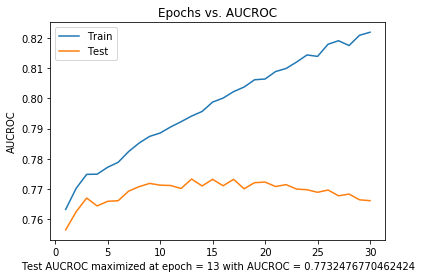

relu 0.7 2 binary_crossentropy 0.33 150 0.2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 5s 124us/step - loss: 0.5249 - acc: 0.7487
Epoch 2/30
43326/43326 [==============================] - 5s 105us/step - loss: 0.4946 - acc: 0.7631
Epoch 3/30
43326/43326 [==============================] - 5s 107us/step - loss: 0.4869 - acc: 0.7665
Epoch 4/30
43326/43326 [==============================] - 5s 107us/step - loss: 0.4860 - acc: 0.7680
Epoch 5/30
43326/43326 [==============================] - 5s 108us/step - loss: 0.4844 - acc: 0.7701
Epoch 6/30
43326/43326 [==============================] - 4s 104us/step - loss: 0.4823 - acc: 0.7690
Epoch 7/30
43326/43326 [==============================] - 5s 106us/step - loss: 0.4811 - acc: 0.7724
Epoch 8/30
43326/43326 [==============================] - 5s 114us/step - loss: 0.4800 - acc: 0.7691
Epoch 9/30
43326/43326 [==============================] - 4s 102us/step - loss: 0.4776 - acc: 0.7740
Epoch 10/30
43326/43326 [==============================] - 4s 102us/step - loss: 0.4761 - a

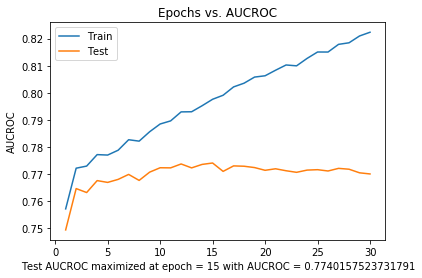

relu 0.7 2 binary_crossentropy 0.33 150 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 6s 135us/step - loss: 0.5302 - acc: 0.7448
Epoch 2/30
43326/43326 [==============================] - 5s 106us/step - loss: 0.4952 - acc: 0.7631
Epoch 3/30
43326/43326 [==============================] - 5s 111us/step - loss: 0.4891 - acc: 0.7666
Epoch 4/30
43326/43326 [==============================] - 5s 105us/step - loss: 0.4875 - acc: 0.7680
Epoch 5/30
43326/43326 [==============================] - 5s 105us/step - loss: 0.4846 - acc: 0.7698
Epoch 6/30
43326/43326 [==============================] - 5s 105us/step - loss: 0.4825 - acc: 0.7711
Epoch 7/30
43326/43326 [==============================] - 5s 106us/step - loss: 0.4808 - acc: 0.7726
Epoch 8/30
43326/43326 [==============================] - 5s 105us/step - loss: 0.4798 - acc: 0.7708
Epoch 9/30
43326/43326 [==============================] - 5s 105us/step - loss: 0.4779 - acc: 0.7727
Epoch 10/30
43326/43326 [==============================] - 5s 104us/step - loss: 0.4761 - a

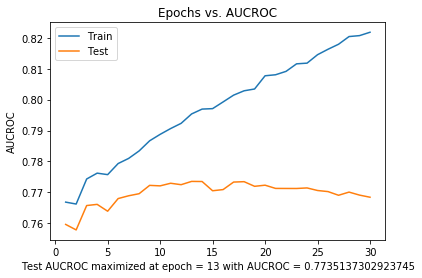

relu 0.7 2 binary_crossentropy 0.33 200 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 6s 140us/step - loss: 0.5270 - acc: 0.7474
Epoch 2/30
43326/43326 [==============================] - 5s 113us/step - loss: 0.4956 - acc: 0.7635
Epoch 3/30
43326/43326 [==============================] - 5s 111us/step - loss: 0.4891 - acc: 0.7659
Epoch 4/30
43326/43326 [==============================] - 5s 119us/step - loss: 0.4872 - acc: 0.7690
Epoch 5/30
43326/43326 [==============================] - 5s 113us/step - loss: 0.4829 - acc: 0.7692
Epoch 6/30
43326/43326 [==============================] - 5s 109us/step - loss: 0.4826 - acc: 0.7688
Epoch 7/30
43326/43326 [==============================] - 5s 116us/step - loss: 0.4794 - acc: 0.7709
Epoch 8/30
43326/43326 [==============================] - 5s 117us/step - loss: 0.4788 - acc: 0.7714
Epoch 9/30
43326/43326 [==============================] - 5s 109us/step - loss: 0.4786 - acc: 0.7745
Epoch 10/30
43326/43326 [==============================] - 5s 110us/step - loss: 0.4755 - a

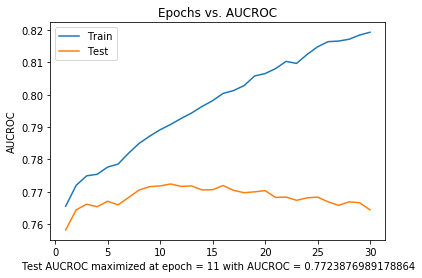

relu 0.7 2 binary_crossentropy 0.33 200 0.2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 6s 142us/step - loss: 0.5291 - acc: 0.7442
Epoch 2/30
43326/43326 [==============================] - 5s 114us/step - loss: 0.4947 - acc: 0.7641
Epoch 3/30
43326/43326 [==============================] - 5s 114us/step - loss: 0.4887 - acc: 0.7657
Epoch 4/30
43326/43326 [==============================] - 5s 113us/step - loss: 0.4866 - acc: 0.7665
Epoch 5/30
43326/43326 [==============================] - 5s 114us/step - loss: 0.4839 - acc: 0.7714
Epoch 6/30
43326/43326 [==============================] - 5s 113us/step - loss: 0.4815 - acc: 0.7714
Epoch 7/30
43326/43326 [==============================] - 5s 116us/step - loss: 0.4809 - acc: 0.7715
Epoch 8/30
43326/43326 [==============================] - 5s 117us/step - loss: 0.4794 - acc: 0.7736
Epoch 9/30
43326/43326 [==============================] - 5s 113us/step - loss: 0.4762 - acc: 0.7759
Epoch 10/30
43326/43326 [==============================] - 5s 113us/step - loss: 0.4753 - a

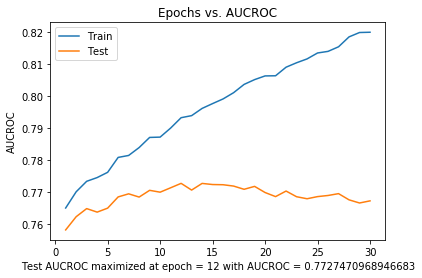

relu 0.7 2 binary_crossentropy 0.33 200 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 6s 142us/step - loss: 0.5347 - acc: 0.7414
Epoch 2/30
43326/43326 [==============================] - 5s 119us/step - loss: 0.4943 - acc: 0.7635
Epoch 3/30
43326/43326 [==============================] - 5s 120us/step - loss: 0.4907 - acc: 0.7665
Epoch 4/30
43326/43326 [==============================] - 5s 124us/step - loss: 0.4869 - acc: 0.7671
Epoch 5/30
43326/43326 [==============================] - 5s 117us/step - loss: 0.4838 - acc: 0.7688
Epoch 6/30
43326/43326 [==============================] - 5s 121us/step - loss: 0.4830 - acc: 0.7704
Epoch 7/30
43326/43326 [==============================] - 5s 115us/step - loss: 0.4802 - acc: 0.7735
Epoch 8/30
43326/43326 [==============================] - 5s 116us/step - loss: 0.4797 - acc: 0.7717
Epoch 9/30
43326/43326 [==============================] - 5s 119us/step - loss: 0.4769 - acc: 0.7750
Epoch 10/30
43326/43326 [==============================] - 5s 115us/step - loss: 0.4775 - a

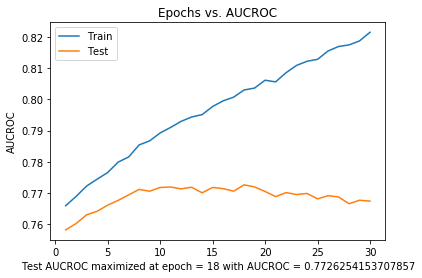

relu 0.8 2 binary_crossentropy 0.33 100 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 6s 129us/step - loss: 0.5375 - acc: 0.7403
Epoch 2/30
43326/43326 [==============================] - 4s 104us/step - loss: 0.5003 - acc: 0.7570
Epoch 3/30
43326/43326 [==============================] - 4s 102us/step - loss: 0.4924 - acc: 0.7640
Epoch 4/30
43326/43326 [==============================] - 5s 104us/step - loss: 0.4876 - acc: 0.7666
Epoch 5/30
43326/43326 [==============================] - 4s 102us/step - loss: 0.4873 - acc: 0.7674
Epoch 6/30
43326/43326 [==============================] - 4s 102us/step - loss: 0.4854 - acc: 0.7679
Epoch 7/30
43326/43326 [==============================] - 4s 102us/step - loss: 0.4833 - acc: 0.7710
Epoch 8/30
43326/43326 [==============================] - 4s 102us/step - loss: 0.4838 - acc: 0.7714
Epoch 9/30
43326/43326 [==============================] - 4s 102us/step - loss: 0.4795 - acc: 0.7724
Epoch 10/30
43326/43326 [==============================] - 4s 102us/step - loss: 0.4788 - a

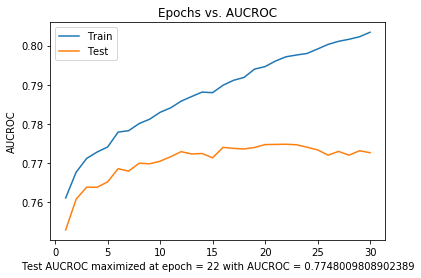

relu 0.8 2 binary_crossentropy 0.33 100 0.2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 6s 136us/step - loss: 0.5295 - acc: 0.7444
Epoch 2/30
43326/43326 [==============================] - 5s 107us/step - loss: 0.4980 - acc: 0.7598
Epoch 3/30
43326/43326 [==============================] - 5s 104us/step - loss: 0.4910 - acc: 0.7646
Epoch 4/30
43326/43326 [==============================] - 4s 101us/step - loss: 0.4882 - acc: 0.7667
Epoch 5/30
43326/43326 [==============================] - 4s 102us/step - loss: 0.4866 - acc: 0.7689
Epoch 6/30
43326/43326 [==============================] - 5s 106us/step - loss: 0.4845 - acc: 0.7697
Epoch 7/30
43326/43326 [==============================] - 5s 104us/step - loss: 0.4839 - acc: 0.7695
Epoch 8/30
43326/43326 [==============================] - 5s 105us/step - loss: 0.4820 - acc: 0.7699
Epoch 9/30
43326/43326 [==============================] - 5s 107us/step - loss: 0.4801 - acc: 0.7710
Epoch 10/30
43326/43326 [==============================] - 5s 105us/step - loss: 0.4794 - a

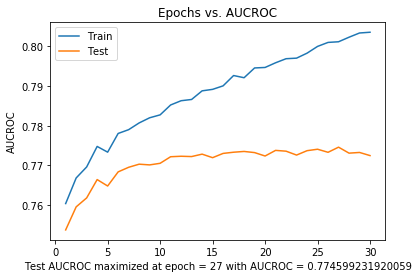

relu 0.8 2 binary_crossentropy 0.33 100 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 6s 135us/step - loss: 0.5423 - acc: 0.7376
Epoch 2/30
43326/43326 [==============================] - 4s 102us/step - loss: 0.4993 - acc: 0.7607
Epoch 3/30
43326/43326 [==============================] - 4s 102us/step - loss: 0.4930 - acc: 0.7622
Epoch 4/30
43326/43326 [==============================] - 4s 102us/step - loss: 0.4903 - acc: 0.7646
Epoch 5/30
43326/43326 [==============================] - 5s 107us/step - loss: 0.4868 - acc: 0.7670
Epoch 6/30
43326/43326 [==============================] - 4s 102us/step - loss: 0.4860 - acc: 0.7675
Epoch 7/30
43326/43326 [==============================] - 5s 110us/step - loss: 0.4838 - acc: 0.7690
Epoch 8/30
43326/43326 [==============================] - 5s 113us/step - loss: 0.4821 - acc: 0.7698
Epoch 9/30
43326/43326 [==============================] - 5s 107us/step - loss: 0.4824 - acc: 0.7698
Epoch 10/30
43326/43326 [==============================] - 5s 121us/step - loss: 0.4800 - a

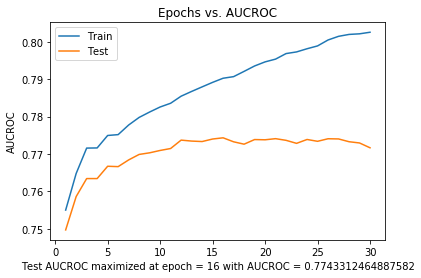

relu 0.8 2 binary_crossentropy 0.33 150 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 6s 144us/step - loss: 0.5356 - acc: 0.7424
Epoch 2/30
43326/43326 [==============================] - 5s 114us/step - loss: 0.4967 - acc: 0.7642
Epoch 3/30
43326/43326 [==============================] - 5s 111us/step - loss: 0.4934 - acc: 0.7623
Epoch 4/30
43326/43326 [==============================] - 5s 118us/step - loss: 0.4887 - acc: 0.7654
Epoch 5/30
43326/43326 [==============================] - 5s 112us/step - loss: 0.4867 - acc: 0.7658
Epoch 6/30
43326/43326 [==============================] - 5s 114us/step - loss: 0.4850 - acc: 0.7694
Epoch 7/30
43326/43326 [==============================] - 5s 121us/step - loss: 0.4839 - acc: 0.7709
Epoch 8/30
43326/43326 [==============================] - 5s 110us/step - loss: 0.4807 - acc: 0.7711
Epoch 9/30
43326/43326 [==============================] - 5s 109us/step - loss: 0.4805 - acc: 0.7713
Epoch 10/30
43326/43326 [==============================] - 5s 112us/step - loss: 0.4804 - a

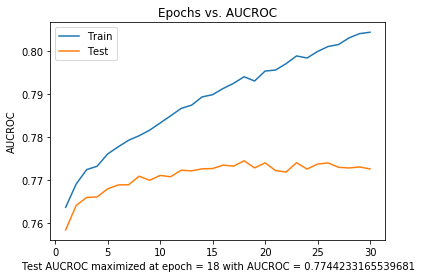

relu 0.8 2 binary_crossentropy 0.33 150 0.2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 7s 152us/step - loss: 0.5339 - acc: 0.7422
Epoch 2/30
43326/43326 [==============================] - 5s 113us/step - loss: 0.4976 - acc: 0.7611
Epoch 3/30
43326/43326 [==============================] - 5s 112us/step - loss: 0.4919 - acc: 0.7649
Epoch 4/30
43326/43326 [==============================] - 5s 114us/step - loss: 0.4881 - acc: 0.7682
Epoch 5/30
43326/43326 [==============================] - 5s 113us/step - loss: 0.4857 - acc: 0.7673
Epoch 6/30
43326/43326 [==============================] - 5s 112us/step - loss: 0.4855 - acc: 0.7685
Epoch 7/30
43326/43326 [==============================] - 5s 112us/step - loss: 0.4844 - acc: 0.7680
Epoch 8/30
43326/43326 [==============================] - 5s 112us/step - loss: 0.4825 - acc: 0.7696
Epoch 9/30
43326/43326 [==============================] - 5s 119us/step - loss: 0.4809 - acc: 0.7709
Epoch 10/30
43326/43326 [==============================] - 5s 112us/step - loss: 0.4805 - a

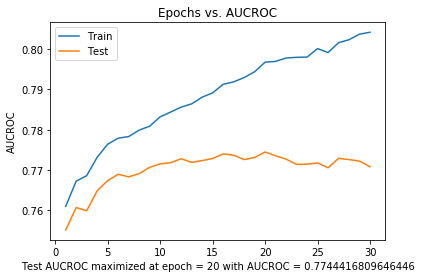

relu 0.8 2 binary_crossentropy 0.33 150 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 6s 147us/step - loss: 0.5389 - acc: 0.7364
Epoch 2/30
43326/43326 [==============================] - 5s 118us/step - loss: 0.4985 - acc: 0.7612
Epoch 3/30
43326/43326 [==============================] - 5s 112us/step - loss: 0.4932 - acc: 0.7632
Epoch 4/30
43326/43326 [==============================] - 5s 113us/step - loss: 0.4900 - acc: 0.7661
Epoch 5/30
43326/43326 [==============================] - 5s 115us/step - loss: 0.4873 - acc: 0.7672
Epoch 6/30
43326/43326 [==============================] - 5s 115us/step - loss: 0.4858 - acc: 0.7666
Epoch 7/30
43326/43326 [==============================] - 5s 114us/step - loss: 0.4846 - acc: 0.7693
Epoch 8/30
43326/43326 [==============================] - 5s 117us/step - loss: 0.4827 - acc: 0.7699
Epoch 9/30
43326/43326 [==============================] - 59s 1ms/step - loss: 0.4829 - acc: 0.7693
Epoch 10/30
43326/43326 [==============================] - 5s 121us/step - loss: 0.4795 - ac

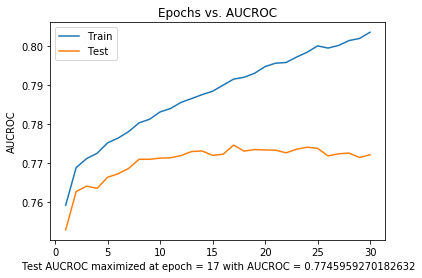

relu 0.8 2 binary_crossentropy 0.33 200 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 7s 163us/step - loss: 0.5368 - acc: 0.7421
Epoch 2/30
43326/43326 [==============================] - 5s 125us/step - loss: 0.4980 - acc: 0.7605
Epoch 3/30
43326/43326 [==============================] - 5s 126us/step - loss: 0.4936 - acc: 0.7634
Epoch 4/30
43326/43326 [==============================] - 5s 124us/step - loss: 0.4893 - acc: 0.7644
Epoch 5/30
43326/43326 [==============================] - 5s 125us/step - loss: 0.4866 - acc: 0.7674
Epoch 6/30
43326/43326 [==============================] - 6s 129us/step - loss: 0.4848 - acc: 0.7702
Epoch 7/30
43326/43326 [==============================] - 5s 125us/step - loss: 0.4847 - acc: 0.7703
Epoch 8/30
43326/43326 [==============================] - 5s 126us/step - loss: 0.4819 - acc: 0.7707
Epoch 9/30
43326/43326 [==============================] - 6s 127us/step - loss: 0.4804 - acc: 0.7719
Epoch 10/30
43326/43326 [==============================] - 5s 126us/step - loss: 0.4798 - a

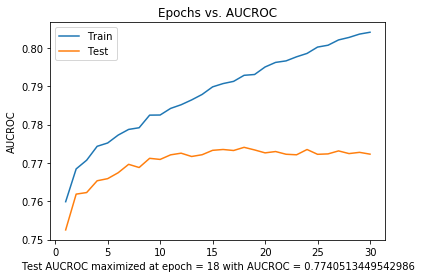

relu 0.8 2 binary_crossentropy 0.33 200 0.2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 7s 159us/step - loss: 0.5448 - acc: 0.7363
Epoch 2/30
43326/43326 [==============================] - 5s 123us/step - loss: 0.4988 - acc: 0.7583
Epoch 3/30
43326/43326 [==============================] - 5s 124us/step - loss: 0.4929 - acc: 0.7622
Epoch 4/30
43326/43326 [==============================] - 5s 125us/step - loss: 0.4905 - acc: 0.7652
Epoch 5/30
43326/43326 [==============================] - 5s 124us/step - loss: 0.4877 - acc: 0.7656
Epoch 6/30
43326/43326 [==============================] - 5s 122us/step - loss: 0.4855 - acc: 0.7677
Epoch 7/30
43326/43326 [==============================] - 36s 830us/step - loss: 0.4845 - acc: 0.7694
Epoch 8/30
43326/43326 [==============================] - 6s 133us/step - loss: 0.4825 - acc: 0.7708
Epoch 9/30
43326/43326 [==============================] - 6s 133us/step - loss: 0.4804 - acc: 0.7726
Epoch 10/30
43326/43326 [==============================] - 5s 126us/step - loss: 0.4802 - 

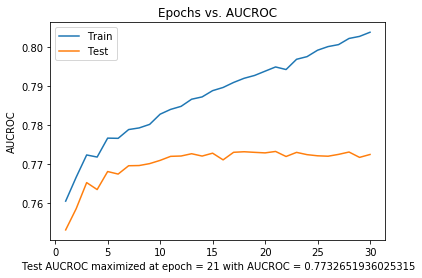

relu 0.8 2 binary_crossentropy 0.33 200 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 7s 166us/step - loss: 0.5390 - acc: 0.7408
Epoch 2/30
43326/43326 [==============================] - 5s 121us/step - loss: 0.4989 - acc: 0.7616
Epoch 3/30
43326/43326 [==============================] - 5s 123us/step - loss: 0.4927 - acc: 0.7652
Epoch 4/30
43326/43326 [==============================] - 5s 123us/step - loss: 0.4903 - acc: 0.7652
Epoch 5/30
43326/43326 [==============================] - 5s 123us/step - loss: 0.4880 - acc: 0.7671
Epoch 6/30
43326/43326 [==============================] - 6s 129us/step - loss: 0.4853 - acc: 0.7701
Epoch 7/30
43326/43326 [==============================] - 6s 127us/step - loss: 0.4852 - acc: 0.7689
Epoch 8/30
43326/43326 [==============================] - 5s 122us/step - loss: 0.4829 - acc: 0.7705
Epoch 9/30
43326/43326 [==============================] - 5s 124us/step - loss: 0.4817 - acc: 0.7702
Epoch 10/30
43326/43326 [==============================] - 5s 124us/step - loss: 0.4810 - a

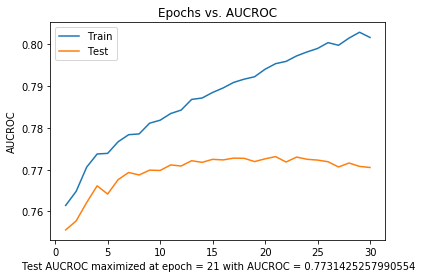

relu 0.9 2 binary_crossentropy 0.33 100 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 7s 166us/step - loss: 0.5452 - acc: 0.7368
Epoch 2/30
43326/43326 [==============================] - 5s 118us/step - loss: 0.5067 - acc: 0.7564
Epoch 3/30
43326/43326 [==============================] - 5s 121us/step - loss: 0.4976 - acc: 0.7624
Epoch 4/30
43326/43326 [==============================] - 5s 118us/step - loss: 0.4935 - acc: 0.7636
Epoch 5/30
43326/43326 [==============================] - 5s 119us/step - loss: 0.4918 - acc: 0.7643
Epoch 6/30
43326/43326 [==============================] - 5s 117us/step - loss: 0.4901 - acc: 0.7653
Epoch 7/30
43326/43326 [==============================] - 5s 110us/step - loss: 0.4886 - acc: 0.7657
Epoch 8/30
43326/43326 [==============================] - 5s 119us/step - loss: 0.4873 - acc: 0.7665
Epoch 9/30
43326/43326 [==============================] - 5s 118us/step - loss: 0.4853 - acc: 0.7682
Epoch 10/30
43326/43326 [==============================] - 5s 119us/step - loss: 0.4837 - a

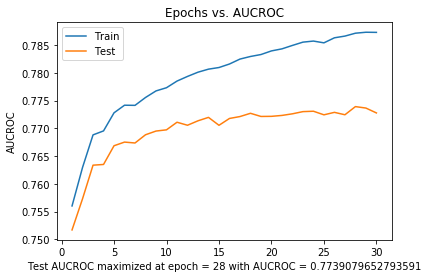

relu 0.9 2 binary_crossentropy 0.33 100 0.2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 7s 165us/step - loss: 0.5475 - acc: 0.7387
Epoch 2/30
43326/43326 [==============================] - 5s 123us/step - loss: 0.5068 - acc: 0.7546
Epoch 3/30
43326/43326 [==============================] - 340s 8ms/step - loss: 0.4972 - acc: 0.7596
Epoch 4/30
43326/43326 [==============================] - 11s 260us/step - loss: 0.4941 - acc: 0.7638
Epoch 5/30
43326/43326 [==============================] - 22s 505us/step - loss: 0.4911 - acc: 0.7661
Epoch 6/30
43326/43326 [==============================] - 5s 121us/step - loss: 0.4902 - acc: 0.7652
Epoch 7/30
43326/43326 [==============================] - 22s 498us/step - loss: 0.4898 - acc: 0.7637
Epoch 8/30
43326/43326 [==============================] - 134s 3ms/step - loss: 0.4878 - acc: 0.7643
Epoch 9/30
43326/43326 [==============================] - 6s 143us/step - loss: 0.4878 - acc: 0.7684
Epoch 10/30
43326/43326 [==============================] - 5s 122us/step - loss: 0.4849 

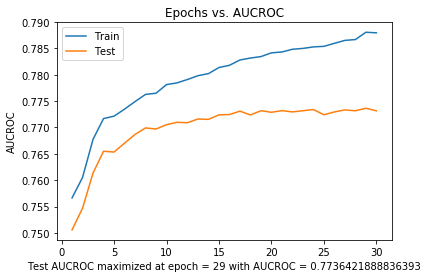

relu 0.9 2 binary_crossentropy 0.33 100 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 7s 171us/step - loss: 0.5513 - acc: 0.7372
Epoch 2/30
43326/43326 [==============================] - 5s 122us/step - loss: 0.5091 - acc: 0.7526
Epoch 3/30
43326/43326 [==============================] - 5s 122us/step - loss: 0.4991 - acc: 0.7601
Epoch 4/30
43326/43326 [==============================] - 5s 122us/step - loss: 0.4953 - acc: 0.7630
Epoch 5/30
43326/43326 [==============================] - 5s 122us/step - loss: 0.4928 - acc: 0.7637
Epoch 6/30
43326/43326 [==============================] - 5s 123us/step - loss: 0.4900 - acc: 0.7645
Epoch 7/30
43326/43326 [==============================] - 5s 119us/step - loss: 0.4895 - acc: 0.7663
Epoch 8/30
43326/43326 [==============================] - 5s 121us/step - loss: 0.4870 - acc: 0.7681
Epoch 9/30
43326/43326 [==============================] - 5s 118us/step - loss: 0.4846 - acc: 0.7687
Epoch 10/30
43326/43326 [==============================] - 5s 121us/step - loss: 0.4851 - a

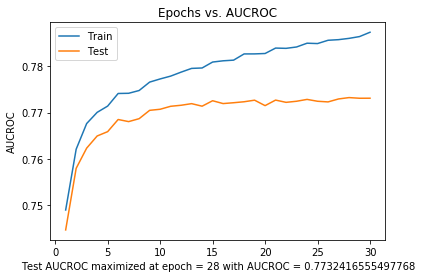

relu 0.9 2 binary_crossentropy 0.33 150 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 7s 170us/step - loss: 0.5489 - acc: 0.7379
Epoch 2/30
43326/43326 [==============================] - 5s 122us/step - loss: 0.5066 - acc: 0.7550
Epoch 3/30
43326/43326 [==============================] - 5s 122us/step - loss: 0.4986 - acc: 0.7582
Epoch 4/30
43326/43326 [==============================] - 5s 123us/step - loss: 0.4955 - acc: 0.7604
Epoch 5/30
43326/43326 [==============================] - 6s 132us/step - loss: 0.4919 - acc: 0.7631
Epoch 6/30
43326/43326 [==============================] - 5s 123us/step - loss: 0.4893 - acc: 0.7634
Epoch 7/30
43326/43326 [==============================] - 5s 121us/step - loss: 0.4888 - acc: 0.7656
Epoch 8/30
43326/43326 [==============================] - 5s 122us/step - loss: 0.4879 - acc: 0.7667
Epoch 9/30
43326/43326 [==============================] - 5s 121us/step - loss: 0.4855 - acc: 0.7695
Epoch 10/30
43326/43326 [==============================] - 5s 125us/step - loss: 0.4859 - a

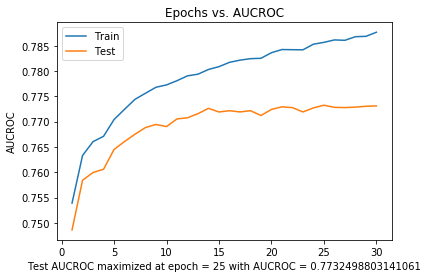

relu 0.9 2 binary_crossentropy 0.33 150 0.2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 8s 175us/step - loss: 0.5490 - acc: 0.7383
Epoch 2/30
43326/43326 [==============================] - 5s 125us/step - loss: 0.5081 - acc: 0.7542
Epoch 3/30
43326/43326 [==============================] - 5s 125us/step - loss: 0.4984 - acc: 0.7594
Epoch 4/30
43326/43326 [==============================] - 5s 126us/step - loss: 0.4948 - acc: 0.7623
Epoch 5/30
43326/43326 [==============================] - 5s 127us/step - loss: 0.4918 - acc: 0.7626
Epoch 6/30
43326/43326 [==============================] - 5s 126us/step - loss: 0.4919 - acc: 0.7617
Epoch 7/30
43326/43326 [==============================] - 6s 129us/step - loss: 0.4884 - acc: 0.7657
Epoch 8/30
43326/43326 [==============================] - 6s 130us/step - loss: 0.4859 - acc: 0.7686
Epoch 9/30
43326/43326 [==============================] - 5s 127us/step - loss: 0.4867 - acc: 0.7670
Epoch 10/30
43326/43326 [==============================] - 5s 126us/step - loss: 0.4853 - a

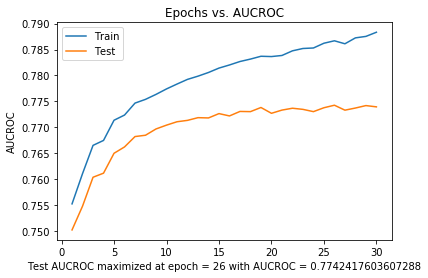

relu 0.9 2 binary_crossentropy 0.33 150 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 8s 176us/step - loss: 0.5518 - acc: 0.7382
Epoch 2/30
43326/43326 [==============================] - 5s 124us/step - loss: 0.5074 - acc: 0.7549
Epoch 3/30
43326/43326 [==============================] - 6s 128us/step - loss: 0.4982 - acc: 0.7598
Epoch 4/30
43326/43326 [==============================] - 6s 130us/step - loss: 0.4952 - acc: 0.7618
Epoch 5/30
43326/43326 [==============================] - 5s 127us/step - loss: 0.4934 - acc: 0.7626
Epoch 6/30
43326/43326 [==============================] - 5s 125us/step - loss: 0.4913 - acc: 0.7634
Epoch 7/30
43326/43326 [==============================] - 5s 123us/step - loss: 0.4894 - acc: 0.7677
Epoch 8/30
43326/43326 [==============================] - 6s 129us/step - loss: 0.4875 - acc: 0.7671
Epoch 9/30
43326/43326 [==============================] - 6s 132us/step - loss: 0.4870 - acc: 0.7660
Epoch 10/30
43326/43326 [==============================] - 5s 127us/step - loss: 0.4858 - a

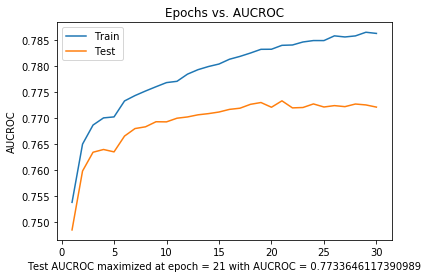

relu 0.9 2 binary_crossentropy 0.33 200 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 8s 188us/step - loss: 0.5459 - acc: 0.7411
Epoch 2/30
43326/43326 [==============================] - 6s 131us/step - loss: 0.5060 - acc: 0.7567
Epoch 3/30
43326/43326 [==============================] - 6s 131us/step - loss: 0.4987 - acc: 0.7581
Epoch 4/30
43326/43326 [==============================] - 6s 132us/step - loss: 0.4957 - acc: 0.7600
Epoch 5/30
43326/43326 [==============================] - 6s 132us/step - loss: 0.4927 - acc: 0.7648
Epoch 6/30
43326/43326 [==============================] - 6s 131us/step - loss: 0.4907 - acc: 0.7653
Epoch 7/30
43326/43326 [==============================] - 6s 131us/step - loss: 0.4891 - acc: 0.7652
Epoch 8/30
43326/43326 [==============================] - 6s 130us/step - loss: 0.4873 - acc: 0.7684
Epoch 9/30
43326/43326 [==============================] - 6s 133us/step - loss: 0.4854 - acc: 0.7697
Epoch 10/30
43326/43326 [==============================] - 6s 142us/step - loss: 0.4860 - a

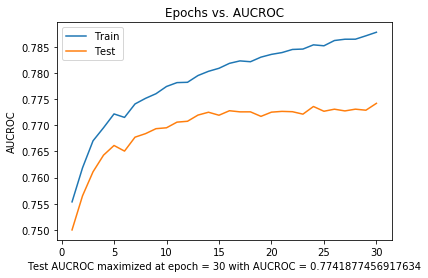

relu 0.9 2 binary_crossentropy 0.33 200 0.2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 9s 201us/step - loss: 0.5496 - acc: 0.7374
Epoch 2/30
43326/43326 [==============================] - 6s 132us/step - loss: 0.5066 - acc: 0.7554
Epoch 3/30
43326/43326 [==============================] - 6s 139us/step - loss: 0.4978 - acc: 0.7606
Epoch 4/30
43326/43326 [==============================] - 6s 135us/step - loss: 0.4943 - acc: 0.7644
Epoch 5/30
43326/43326 [==============================] - 6s 132us/step - loss: 0.4930 - acc: 0.7636
Epoch 6/30
43326/43326 [==============================] - 6s 136us/step - loss: 0.4895 - acc: 0.7658
Epoch 7/30
43326/43326 [==============================] - 6s 139us/step - loss: 0.4887 - acc: 0.7679
Epoch 8/30
43326/43326 [==============================] - 6s 144us/step - loss: 0.4882 - acc: 0.7679
Epoch 9/30
43326/43326 [==============================] - 6s 131us/step - loss: 0.4857 - acc: 0.7680
Epoch 10/30
43326/43326 [==============================] - 6s 135us/step - loss: 0.4858 - a

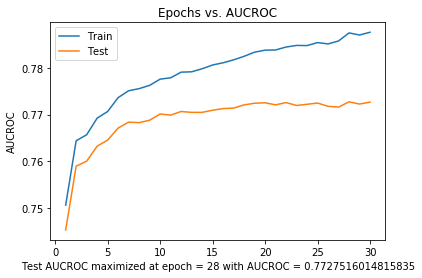

relu 0.9 2 binary_crossentropy 0.33 200 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 9s 200us/step - loss: 0.5509 - acc: 0.7384
Epoch 2/30
43326/43326 [==============================] - 6s 141us/step - loss: 0.5077 - acc: 0.7554
Epoch 3/30
43326/43326 [==============================] - 6s 141us/step - loss: 0.4994 - acc: 0.7595
Epoch 4/30
43326/43326 [==============================] - 6s 147us/step - loss: 0.4948 - acc: 0.7621
Epoch 5/30
43326/43326 [==============================] - 6s 143us/step - loss: 0.4937 - acc: 0.7632
Epoch 6/30
43326/43326 [==============================] - 6s 148us/step - loss: 0.4901 - acc: 0.7636
Epoch 7/30
43326/43326 [==============================] - 6s 146us/step - loss: 0.4904 - acc: 0.7661
Epoch 8/30
43326/43326 [==============================] - 7s 161us/step - loss: 0.4883 - acc: 0.7665
Epoch 9/30
43326/43326 [==============================] - 6s 149us/step - loss: 0.4875 - acc: 0.7664
Epoch 10/30
43326/43326 [==============================] - 6s 149us/step - loss: 0.4865 - a

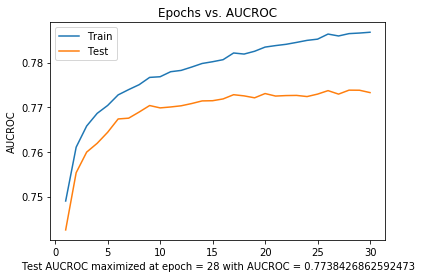

tanh 0.7 2 binary_crossentropy 0.33 100 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 8s 193us/step - loss: 0.5230 - acc: 0.7460
Epoch 2/30
43326/43326 [==============================] - 6s 127us/step - loss: 0.4964 - acc: 0.7620
Epoch 3/30
43326/43326 [==============================] - 5s 125us/step - loss: 0.4903 - acc: 0.7649
Epoch 4/30
43326/43326 [==============================] - 5s 126us/step - loss: 0.4872 - acc: 0.7693
Epoch 5/30
43326/43326 [==============================] - 6s 127us/step - loss: 0.4863 - acc: 0.7684
Epoch 6/30
43326/43326 [==============================] - 6s 127us/step - loss: 0.4835 - acc: 0.7710
Epoch 7/30
43326/43326 [==============================] - 5s 125us/step - loss: 0.4817 - acc: 0.7721
Epoch 8/30
43326/43326 [==============================] - 6s 130us/step - loss: 0.4796 - acc: 0.7733
Epoch 9/30
43326/43326 [==============================] - 5s 123us/step - loss: 0.4785 - acc: 0.7731
Epoch 10/30
43326/43326 [==============================] - 5s 126us/step - loss: 0.4757 - a

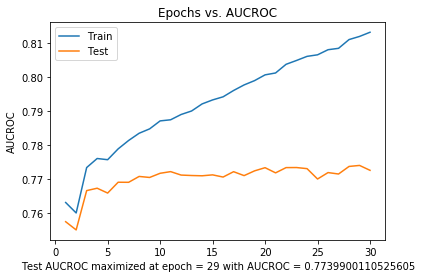

tanh 0.7 2 binary_crossentropy 0.33 100 0.2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 8s 189us/step - loss: 0.5259 - acc: 0.7432
Epoch 2/30
43326/43326 [==============================] - 6s 136us/step - loss: 0.4950 - acc: 0.7634
Epoch 3/30
43326/43326 [==============================] - 6s 134us/step - loss: 0.4896 - acc: 0.7664
Epoch 4/30
43326/43326 [==============================] - 5s 126us/step - loss: 0.4874 - acc: 0.7688
Epoch 5/30
43326/43326 [==============================] - 6s 146us/step - loss: 0.4856 - acc: 0.7671
Epoch 6/30
43326/43326 [==============================] - 5s 126us/step - loss: 0.4828 - acc: 0.7711
Epoch 7/30
43326/43326 [==============================] - 6s 127us/step - loss: 0.4809 - acc: 0.7719
Epoch 8/30
43326/43326 [==============================] - 5s 125us/step - loss: 0.4814 - acc: 0.7713
Epoch 9/30
43326/43326 [==============================] - 5s 127us/step - loss: 0.4791 - acc: 0.7733
Epoch 10/30
43326/43326 [==============================] - 5s 125us/step - loss: 0.4774 - a

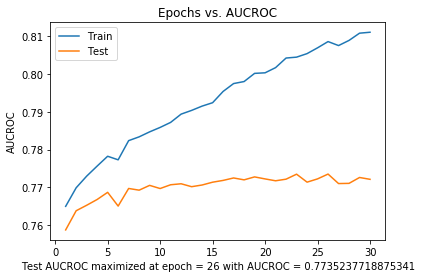

tanh 0.7 2 binary_crossentropy 0.33 100 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 8s 184us/step - loss: 0.5233 - acc: 0.7452
Epoch 2/30
43326/43326 [==============================] - 5s 122us/step - loss: 0.4943 - acc: 0.7638
Epoch 3/30
43326/43326 [==============================] - 5s 121us/step - loss: 0.4899 - acc: 0.7662
Epoch 4/30
43326/43326 [==============================] - 5s 121us/step - loss: 0.4890 - acc: 0.7677
Epoch 5/30
43326/43326 [==============================] - 5s 120us/step - loss: 0.4862 - acc: 0.7691
Epoch 6/30
43326/43326 [==============================] - 5s 121us/step - loss: 0.4832 - acc: 0.7716
Epoch 7/30
43326/43326 [==============================] - 5s 121us/step - loss: 0.4829 - acc: 0.7712
Epoch 8/30
43326/43326 [==============================] - 5s 121us/step - loss: 0.4808 - acc: 0.7719
Epoch 9/30
43326/43326 [==============================] - 5s 121us/step - loss: 0.4802 - acc: 0.7727
Epoch 10/30
43326/43326 [==============================] - 5s 121us/step - loss: 0.4775 - a

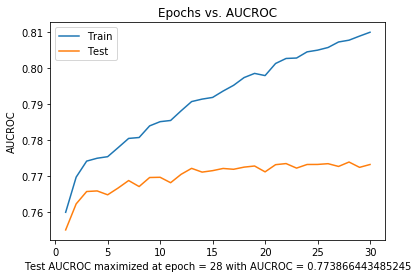

tanh 0.7 2 binary_crossentropy 0.33 150 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 9s 207us/step - loss: 0.5230 - acc: 0.7474
Epoch 2/30
43326/43326 [==============================] - 6s 131us/step - loss: 0.4958 - acc: 0.7617
Epoch 3/30
43326/43326 [==============================] - 6s 130us/step - loss: 0.4897 - acc: 0.7662
Epoch 4/30
43326/43326 [==============================] - 6s 131us/step - loss: 0.4861 - acc: 0.7683
Epoch 5/30
43326/43326 [==============================] - 6s 130us/step - loss: 0.4842 - acc: 0.7700
Epoch 6/30
43326/43326 [==============================] - 6s 130us/step - loss: 0.4835 - acc: 0.7709
Epoch 7/30
43326/43326 [==============================] - 6s 132us/step - loss: 0.4822 - acc: 0.7699
Epoch 8/30
43326/43326 [==============================] - 6s 130us/step - loss: 0.4800 - acc: 0.7741
Epoch 9/30
43326/43326 [==============================] - 6s 131us/step - loss: 0.4791 - acc: 0.7730
Epoch 10/30
43326/43326 [==============================] - 6s 138us/step - loss: 0.4781 - a

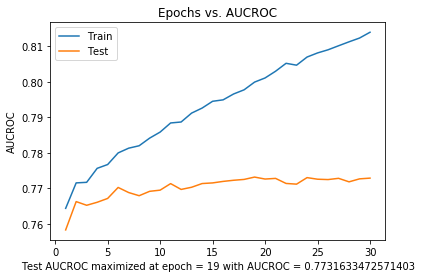

tanh 0.7 2 binary_crossentropy 0.33 150 0.2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 9s 205us/step - loss: 0.5194 - acc: 0.7493
Epoch 2/30
43326/43326 [==============================] - 6s 135us/step - loss: 0.4951 - acc: 0.7616
Epoch 3/30
43326/43326 [==============================] - 7s 153us/step - loss: 0.4901 - acc: 0.7667
Epoch 4/30
43326/43326 [==============================] - 7s 156us/step - loss: 0.4871 - acc: 0.7679
Epoch 5/30
43326/43326 [==============================] - 7s 157us/step - loss: 0.4860 - acc: 0.7679
Epoch 6/30
43326/43326 [==============================] - 6s 146us/step - loss: 0.4842 - acc: 0.7692
Epoch 7/30
43326/43326 [==============================] - 7s 153us/step - loss: 0.4817 - acc: 0.7718
Epoch 8/30
43326/43326 [==============================] - 6s 145us/step - loss: 0.4803 - acc: 0.7738
Epoch 9/30
43326/43326 [==============================] - 6s 148us/step - loss: 0.4781 - acc: 0.7722
Epoch 10/30
43326/43326 [==============================] - 6s 148us/step - loss: 0.4766 - a

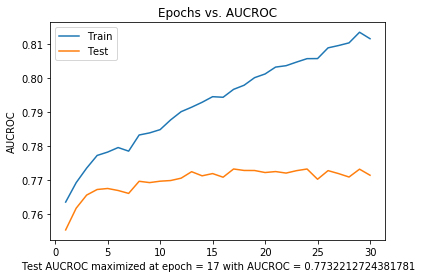

tanh 0.7 2 binary_crossentropy 0.33 150 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 9s 199us/step - loss: 0.5261 - acc: 0.7459
Epoch 2/30
43326/43326 [==============================] - 6s 132us/step - loss: 0.4969 - acc: 0.7608
Epoch 3/30
43326/43326 [==============================] - 6s 133us/step - loss: 0.4909 - acc: 0.7665
Epoch 4/30
43326/43326 [==============================] - 6s 140us/step - loss: 0.4876 - acc: 0.7681
Epoch 5/30
43326/43326 [==============================] - 6s 142us/step - loss: 0.4862 - acc: 0.7691
Epoch 6/30
43326/43326 [==============================] - 6s 144us/step - loss: 0.4850 - acc: 0.7697
Epoch 7/30
43326/43326 [==============================] - 6s 149us/step - loss: 0.4822 - acc: 0.7709
Epoch 8/30
43326/43326 [==============================] - 6s 134us/step - loss: 0.4805 - acc: 0.7737
Epoch 9/30
43326/43326 [==============================] - 6s 143us/step - loss: 0.4804 - acc: 0.7722
Epoch 10/30
43326/43326 [==============================] - 6s 136us/step - loss: 0.4806 - a

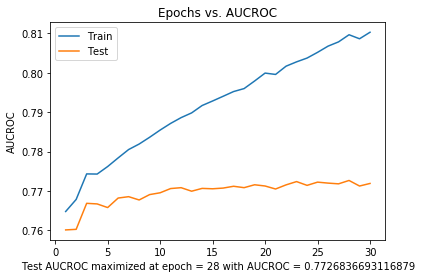

tanh 0.7 2 binary_crossentropy 0.33 200 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 9s 212us/step - loss: 0.5203 - acc: 0.7486
Epoch 2/30
43326/43326 [==============================] - 6s 139us/step - loss: 0.4949 - acc: 0.7623
Epoch 3/30
43326/43326 [==============================] - 6s 140us/step - loss: 0.4899 - acc: 0.7673
Epoch 4/30
43326/43326 [==============================] - 6s 139us/step - loss: 0.4869 - acc: 0.7681
Epoch 5/30
43326/43326 [==============================] - 6s 139us/step - loss: 0.4865 - acc: 0.7683
Epoch 6/30
43326/43326 [==============================] - 6s 140us/step - loss: 0.4826 - acc: 0.7708
Epoch 7/30
43326/43326 [==============================] - 6s 139us/step - loss: 0.4832 - acc: 0.7712
Epoch 8/30
43326/43326 [==============================] - 6s 139us/step - loss: 0.4803 - acc: 0.7733
Epoch 9/30
43326/43326 [==============================] - 6s 140us/step - loss: 0.4793 - acc: 0.7734
Epoch 10/30
43326/43326 [==============================] - 6s 139us/step - loss: 0.4770 - a

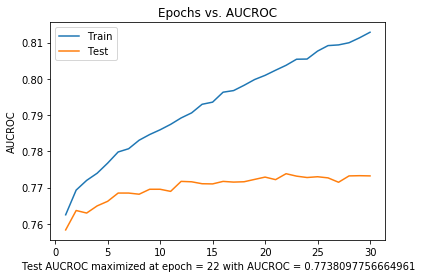

tanh 0.7 2 binary_crossentropy 0.33 200 0.2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 10s 221us/step - loss: 0.5225 - acc: 0.7482
Epoch 2/30
43326/43326 [==============================] - 6s 144us/step - loss: 0.4954 - acc: 0.7603
Epoch 3/30
43326/43326 [==============================] - 6s 142us/step - loss: 0.4900 - acc: 0.7636
Epoch 4/30
43326/43326 [==============================] - 6s 146us/step - loss: 0.4888 - acc: 0.7676
Epoch 5/30
43326/43326 [==============================] - 6s 143us/step - loss: 0.4849 - acc: 0.7691
Epoch 6/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.4835 - acc: 0.7708
Epoch 7/30
43326/43326 [==============================] - 6s 146us/step - loss: 0.4823 - acc: 0.7730
Epoch 8/30
43326/43326 [==============================] - 6s 146us/step - loss: 0.4804 - acc: 0.7719
Epoch 9/30
43326/43326 [==============================] - 6s 149us/step - loss: 0.4797 - acc: 0.7728
Epoch 10/30
43326/43326 [==============================] - 6s 147us/step - loss: 0.4774 - 

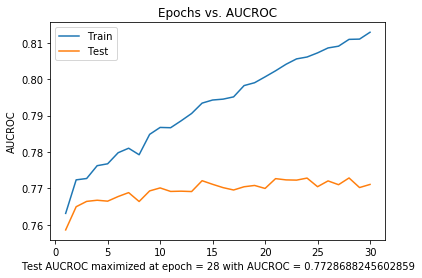

tanh 0.7 2 binary_crossentropy 0.33 200 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 10s 221us/step - loss: 0.5304 - acc: 0.7417
Epoch 2/30
43326/43326 [==============================] - 6s 146us/step - loss: 0.4956 - acc: 0.7620
Epoch 3/30
43326/43326 [==============================] - 6s 147us/step - loss: 0.4918 - acc: 0.7657
Epoch 4/30
43326/43326 [==============================] - 6s 147us/step - loss: 0.4886 - acc: 0.7679
Epoch 5/30
43326/43326 [==============================] - 6s 145us/step - loss: 0.4875 - acc: 0.7677
Epoch 6/30
43326/43326 [==============================] - 6s 144us/step - loss: 0.4853 - acc: 0.7684
Epoch 7/30
43326/43326 [==============================] - 6s 143us/step - loss: 0.4844 - acc: 0.7703
Epoch 8/30
43326/43326 [==============================] - 7s 152us/step - loss: 0.4817 - acc: 0.7720
Epoch 9/30
43326/43326 [==============================] - 6s 146us/step - loss: 0.4804 - acc: 0.7737
Epoch 10/30
43326/43326 [==============================] - 6s 144us/step - loss: 0.4798 - 

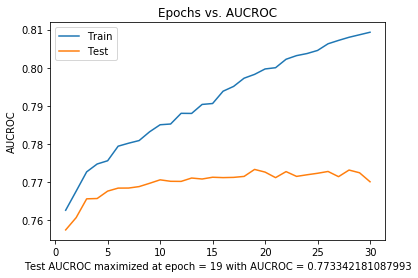

tanh 0.8 2 binary_crossentropy 0.33 100 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 9s 204us/step - loss: 0.5264 - acc: 0.7447
Epoch 2/30
43326/43326 [==============================] - 6s 129us/step - loss: 0.4987 - acc: 0.7592
Epoch 3/30
43326/43326 [==============================] - 6s 130us/step - loss: 0.4928 - acc: 0.7634
Epoch 4/30
43326/43326 [==============================] - 6s 129us/step - loss: 0.4900 - acc: 0.7662
Epoch 5/30
43326/43326 [==============================] - 6s 130us/step - loss: 0.4879 - acc: 0.7666
Epoch 6/30
43326/43326 [==============================] - 6s 129us/step - loss: 0.4872 - acc: 0.7682
Epoch 7/30
43326/43326 [==============================] - 6s 139us/step - loss: 0.4862 - acc: 0.7680
Epoch 8/30
43326/43326 [==============================] - 6s 144us/step - loss: 0.4845 - acc: 0.7690
Epoch 9/30
43326/43326 [==============================] - 6s 130us/step - loss: 0.4823 - acc: 0.7704
Epoch 10/30
43326/43326 [==============================] - 6s 129us/step - loss: 0.4808 - a

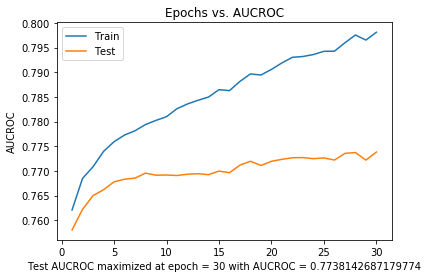

tanh 0.8 2 binary_crossentropy 0.33 100 0.2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 9s 206us/step - loss: 0.5323 - acc: 0.7420
Epoch 2/30
43326/43326 [==============================] - 6s 131us/step - loss: 0.4983 - acc: 0.7588
Epoch 3/30
43326/43326 [==============================] - 6s 131us/step - loss: 0.4947 - acc: 0.7621
Epoch 4/30
43326/43326 [==============================] - 6s 129us/step - loss: 0.4900 - acc: 0.7660
Epoch 5/30
43326/43326 [==============================] - 6s 129us/step - loss: 0.4869 - acc: 0.7675
Epoch 6/30
43326/43326 [==============================] - 6s 129us/step - loss: 0.4874 - acc: 0.7680
Epoch 7/30
43326/43326 [==============================] - 6s 128us/step - loss: 0.4841 - acc: 0.7715
Epoch 8/30
43326/43326 [==============================] - 6s 129us/step - loss: 0.4839 - acc: 0.7684
Epoch 9/30
43326/43326 [==============================] - 6s 131us/step - loss: 0.4829 - acc: 0.7715
Epoch 10/30
43326/43326 [==============================] - 6s 130us/step - loss: 0.4816 - a

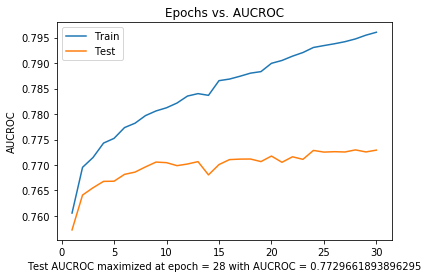

tanh 0.8 2 binary_crossentropy 0.33 100 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 10s 220us/step - loss: 0.5370 - acc: 0.7378
Epoch 2/30
43326/43326 [==============================] - 6s 131us/step - loss: 0.4986 - acc: 0.7609
Epoch 3/30
43326/43326 [==============================] - 6s 130us/step - loss: 0.4933 - acc: 0.7619
Epoch 4/30
43326/43326 [==============================] - 6s 131us/step - loss: 0.4910 - acc: 0.7648
Epoch 5/30
43326/43326 [==============================] - 6s 131us/step - loss: 0.4889 - acc: 0.7665
Epoch 6/30
43326/43326 [==============================] - 6s 134us/step - loss: 0.4881 - acc: 0.7656
Epoch 7/30
43326/43326 [==============================] - 6s 131us/step - loss: 0.4845 - acc: 0.7707
Epoch 8/30
43326/43326 [==============================] - 6s 131us/step - loss: 0.4843 - acc: 0.7688
Epoch 9/30
43326/43326 [==============================] - 6s 130us/step - loss: 0.4817 - acc: 0.7704
Epoch 10/30
43326/43326 [==============================] - 6s 131us/step - loss: 0.4814 - 

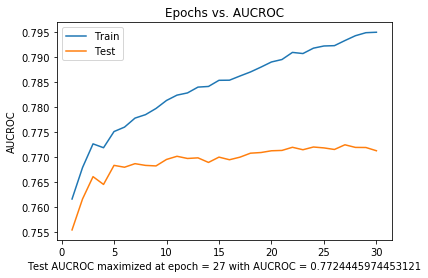

tanh 0.8 2 binary_crossentropy 0.33 150 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 10s 234us/step - loss: 0.5324 - acc: 0.7405
Epoch 2/30
43326/43326 [==============================] - 6s 150us/step - loss: 0.4984 - acc: 0.7603
Epoch 3/30
43326/43326 [==============================] - 6s 150us/step - loss: 0.4915 - acc: 0.7650
Epoch 4/30
43326/43326 [==============================] - 6s 150us/step - loss: 0.4898 - acc: 0.7661
Epoch 5/30
43326/43326 [==============================] - 6s 149us/step - loss: 0.4902 - acc: 0.7649
Epoch 6/30
43326/43326 [==============================] - 6s 150us/step - loss: 0.4853 - acc: 0.7713
Epoch 7/30
43326/43326 [==============================] - 6s 150us/step - loss: 0.4854 - acc: 0.7700
Epoch 8/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.4830 - acc: 0.7709
Epoch 9/30
43326/43326 [==============================] - 7s 158us/step - loss: 0.4818 - acc: 0.7729
Epoch 10/30
43326/43326 [==============================] - 6s 149us/step - loss: 0.4812 - 

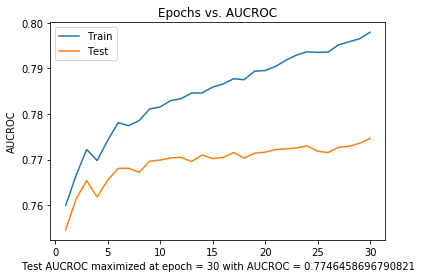

tanh 0.8 2 binary_crossentropy 0.33 150 0.2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 10s 223us/step - loss: 0.5332 - acc: 0.7412
Epoch 2/30
43326/43326 [==============================] - 7s 152us/step - loss: 0.4976 - acc: 0.7592
Epoch 3/30
43326/43326 [==============================] - 7s 155us/step - loss: 0.4930 - acc: 0.7630
Epoch 4/30
43326/43326 [==============================] - 7s 155us/step - loss: 0.4913 - acc: 0.7652
Epoch 5/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.4875 - acc: 0.7662
Epoch 6/30
43326/43326 [==============================] - 7s 151us/step - loss: 0.4870 - acc: 0.7671
Epoch 7/30
43326/43326 [==============================] - 7s 152us/step - loss: 0.4864 - acc: 0.7690
Epoch 8/30
43326/43326 [==============================] - 7s 152us/step - loss: 0.4841 - acc: 0.7709
Epoch 9/30
43326/43326 [==============================] - 7s 153us/step - loss: 0.4820 - acc: 0.7693
Epoch 10/30
43326/43326 [==============================] - 7s 152us/step - loss: 0.4819 - 

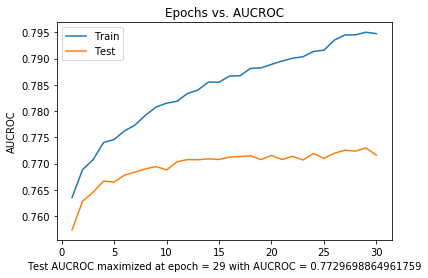

tanh 0.8 2 binary_crossentropy 0.33 150 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 10s 237us/step - loss: 0.5359 - acc: 0.7405
Epoch 2/30
43326/43326 [==============================] - 6s 141us/step - loss: 0.4990 - acc: 0.7590
Epoch 3/30
43326/43326 [==============================] - 7s 151us/step - loss: 0.4934 - acc: 0.7636
Epoch 4/30
43326/43326 [==============================] - 6s 141us/step - loss: 0.4910 - acc: 0.7667
Epoch 5/30
43326/43326 [==============================] - 6s 140us/step - loss: 0.4883 - acc: 0.7681
Epoch 6/30
43326/43326 [==============================] - 6s 141us/step - loss: 0.4861 - acc: 0.7691
Epoch 7/30
43326/43326 [==============================] - 6s 141us/step - loss: 0.4880 - acc: 0.7672
Epoch 8/30
43326/43326 [==============================] - 6s 141us/step - loss: 0.4851 - acc: 0.7697
Epoch 9/30
43326/43326 [==============================] - 7s 151us/step - loss: 0.4831 - acc: 0.7719
Epoch 10/30
43326/43326 [==============================] - 6s 143us/step - loss: 0.4840 - 

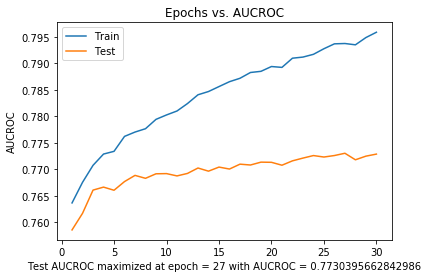

tanh 0.8 2 binary_crossentropy 0.33 200 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 11s 250us/step - loss: 0.5259 - acc: 0.7451
Epoch 2/30
43326/43326 [==============================] - 7s 157us/step - loss: 0.4993 - acc: 0.7615
Epoch 3/30
43326/43326 [==============================] - 7s 159us/step - loss: 0.4937 - acc: 0.7638
Epoch 4/30
43326/43326 [==============================] - 7s 158us/step - loss: 0.4908 - acc: 0.7662
Epoch 5/30
43326/43326 [==============================] - 7s 158us/step - loss: 0.4885 - acc: 0.7671
Epoch 6/30
43326/43326 [==============================] - 7s 157us/step - loss: 0.4882 - acc: 0.7682
Epoch 7/30
43326/43326 [==============================] - 7s 157us/step - loss: 0.4860 - acc: 0.7680
Epoch 8/30
43326/43326 [==============================] - 7s 158us/step - loss: 0.4852 - acc: 0.7712
Epoch 9/30
43326/43326 [==============================] - 7s 158us/step - loss: 0.4824 - acc: 0.7722
Epoch 10/30
43326/43326 [==============================] - 7s 165us/step - loss: 0.4820 - 

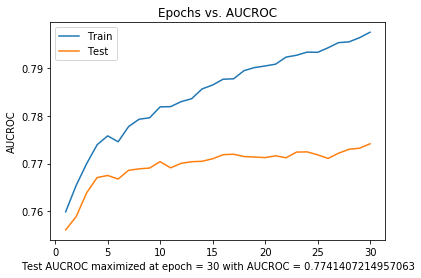

tanh 0.8 2 binary_crossentropy 0.33 200 0.2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 10s 237us/step - loss: 0.5319 - acc: 0.7426
Epoch 2/30
43326/43326 [==============================] - 7s 151us/step - loss: 0.4994 - acc: 0.7590
Epoch 3/30
43326/43326 [==============================] - 7s 151us/step - loss: 0.4935 - acc: 0.7641
Epoch 4/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.4920 - acc: 0.7641
Epoch 5/30
43326/43326 [==============================] - 7s 151us/step - loss: 0.4888 - acc: 0.7671
Epoch 6/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.4869 - acc: 0.7703
Epoch 7/30
43326/43326 [==============================] - 7s 150us/step - loss: 0.4849 - acc: 0.7701
Epoch 8/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.4849 - acc: 0.7684
Epoch 9/30
43326/43326 [==============================] - 7s 151us/step - loss: 0.4839 - acc: 0.7695
Epoch 10/30
43326/43326 [==============================] - 7s 151us/step - loss: 0.4823 - 

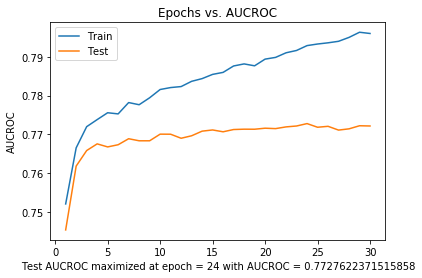

tanh 0.8 2 binary_crossentropy 0.33 200 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 11s 248us/step - loss: 0.5352 - acc: 0.7395
Epoch 2/30
43326/43326 [==============================] - 7s 157us/step - loss: 0.4996 - acc: 0.7603
Epoch 3/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.4944 - acc: 0.7629
Epoch 4/30
43326/43326 [==============================] - 7s 153us/step - loss: 0.4912 - acc: 0.7634
Epoch 5/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.4896 - acc: 0.7665
Epoch 6/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.4877 - acc: 0.7685
Epoch 7/30
43326/43326 [==============================] - 7s 153us/step - loss: 0.4864 - acc: 0.7701
Epoch 8/30
43326/43326 [==============================] - 7s 155us/step - loss: 0.4859 - acc: 0.7696
Epoch 9/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.4843 - acc: 0.7694
Epoch 10/30
43326/43326 [==============================] - 7s 155us/step - loss: 0.4831 - 

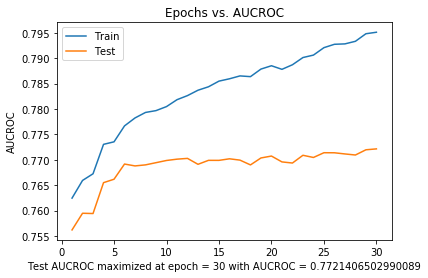

tanh 0.9 2 binary_crossentropy 0.33 100 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 10s 233us/step - loss: 0.5394 - acc: 0.7393
Epoch 2/30
43326/43326 [==============================] - 6s 139us/step - loss: 0.5041 - acc: 0.7574
Epoch 3/30
43326/43326 [==============================] - 6s 139us/step - loss: 0.4988 - acc: 0.7581
Epoch 4/30
43326/43326 [==============================] - 6s 149us/step - loss: 0.4955 - acc: 0.7604
Epoch 5/30
43326/43326 [==============================] - 6s 139us/step - loss: 0.4944 - acc: 0.7614
Epoch 6/30
43326/43326 [==============================] - 6s 139us/step - loss: 0.4920 - acc: 0.7630
Epoch 7/30
43326/43326 [==============================] - 6s 139us/step - loss: 0.4899 - acc: 0.7653
Epoch 8/30
43326/43326 [==============================] - 6s 139us/step - loss: 0.4886 - acc: 0.7678
Epoch 9/30
43326/43326 [==============================] - 6s 140us/step - loss: 0.4882 - acc: 0.7664
Epoch 10/30
43326/43326 [==============================] - 6s 140us/step - loss: 0.4865 - 

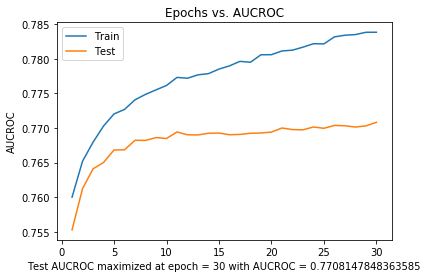

tanh 0.9 2 binary_crossentropy 0.33 100 0.2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 10s 239us/step - loss: 0.5402 - acc: 0.7373
Epoch 2/30
43326/43326 [==============================] - 7s 157us/step - loss: 0.5060 - acc: 0.7532
Epoch 3/30
43326/43326 [==============================] - 7s 153us/step - loss: 0.4988 - acc: 0.7587
Epoch 4/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.4962 - acc: 0.7628
Epoch 5/30
43326/43326 [==============================] - 7s 164us/step - loss: 0.4939 - acc: 0.7622
Epoch 6/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.4922 - acc: 0.7650
Epoch 7/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.4913 - acc: 0.7657
Epoch 8/30
43326/43326 [==============================] - 7s 153us/step - loss: 0.4896 - acc: 0.7667
Epoch 9/30
43326/43326 [==============================] - 7s 153us/step - loss: 0.4882 - acc: 0.7669
Epoch 10/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.4868 - 

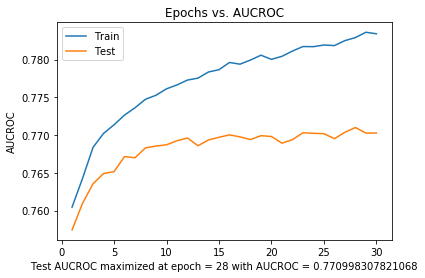

tanh 0.9 2 binary_crossentropy 0.33 100 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 11s 258us/step - loss: 0.5506 - acc: 0.7334
Epoch 2/30
43326/43326 [==============================] - 7s 172us/step - loss: 0.5070 - acc: 0.7546
Epoch 3/30
43326/43326 [==============================] - 7s 153us/step - loss: 0.4998 - acc: 0.7575
Epoch 4/30
43326/43326 [==============================] - 7s 166us/step - loss: 0.4960 - acc: 0.7621
Epoch 5/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.4938 - acc: 0.7622
Epoch 6/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.4914 - acc: 0.7631
Epoch 7/30
43326/43326 [==============================] - 7s 155us/step - loss: 0.4906 - acc: 0.7657
Epoch 8/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.4888 - acc: 0.7649
Epoch 9/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.4887 - acc: 0.7670
Epoch 10/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.4869 - 

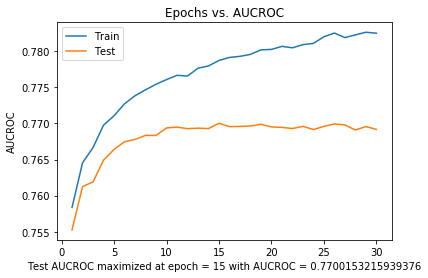

tanh 0.9 2 binary_crossentropy 0.33 150 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 11s 252us/step - loss: 0.5398 - acc: 0.7401
Epoch 2/30
43326/43326 [==============================] - 7s 152us/step - loss: 0.5040 - acc: 0.7560
Epoch 3/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.5002 - acc: 0.7583
Epoch 4/30
43326/43326 [==============================] - 7s 152us/step - loss: 0.4970 - acc: 0.7623
Epoch 5/30
43326/43326 [==============================] - 7s 161us/step - loss: 0.4946 - acc: 0.7632
Epoch 6/30
43326/43326 [==============================] - 7s 151us/step - loss: 0.4928 - acc: 0.7628
Epoch 7/30
43326/43326 [==============================] - 7s 151us/step - loss: 0.4905 - acc: 0.7641
Epoch 8/30
43326/43326 [==============================] - 7s 153us/step - loss: 0.4888 - acc: 0.7661
Epoch 9/30
43326/43326 [==============================] - 7s 152us/step - loss: 0.4886 - acc: 0.7679
Epoch 10/30
43326/43326 [==============================] - 7s 152us/step - loss: 0.4877 - 

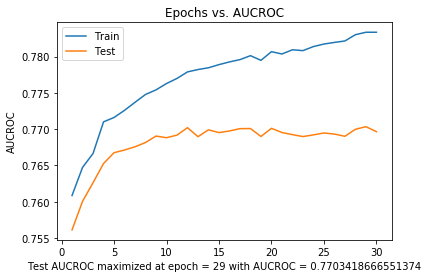

tanh 0.9 2 binary_crossentropy 0.33 150 0.2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 11s 255us/step - loss: 0.5457 - acc: 0.7335
Epoch 2/30
43326/43326 [==============================] - 7s 155us/step - loss: 0.5057 - acc: 0.7539
Epoch 3/30
43326/43326 [==============================] - 7s 153us/step - loss: 0.4985 - acc: 0.7598
Epoch 4/30
43326/43326 [==============================] - 7s 156us/step - loss: 0.4960 - acc: 0.7608
Epoch 5/30
43326/43326 [==============================] - 7s 155us/step - loss: 0.4922 - acc: 0.7647
Epoch 6/30
43326/43326 [==============================] - 7s 153us/step - loss: 0.4928 - acc: 0.7646
Epoch 7/30
43326/43326 [==============================] - 7s 152us/step - loss: 0.4902 - acc: 0.7653
Epoch 8/30
43326/43326 [==============================] - 7s 152us/step - loss: 0.4901 - acc: 0.7658
Epoch 9/30
43326/43326 [==============================] - 7s 154us/step - loss: 0.4889 - acc: 0.7653
Epoch 10/30
43326/43326 [==============================] - 7s 153us/step - loss: 0.4868 - 

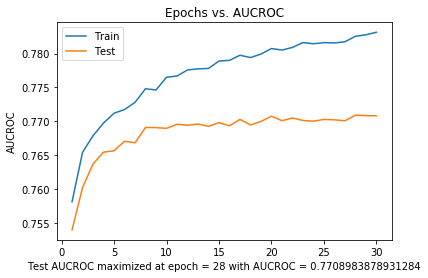

tanh 0.9 2 binary_crossentropy 0.33 150 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 12s 276us/step - loss: 0.5410 - acc: 0.7390
Epoch 2/30
43326/43326 [==============================] - 7s 158us/step - loss: 0.5055 - acc: 0.7529
Epoch 3/30
43326/43326 [==============================] - 7s 159us/step - loss: 0.5006 - acc: 0.7583
Epoch 4/30
43326/43326 [==============================] - 7s 160us/step - loss: 0.4980 - acc: 0.7608
Epoch 5/30
43326/43326 [==============================] - 7s 157us/step - loss: 0.4952 - acc: 0.7627
Epoch 6/30
43326/43326 [==============================] - 7s 169us/step - loss: 0.4911 - acc: 0.7648
Epoch 7/30
43326/43326 [==============================] - 8s 178us/step - loss: 0.4916 - acc: 0.7643
Epoch 8/30
43326/43326 [==============================] - 7s 158us/step - loss: 0.4903 - acc: 0.7657
Epoch 9/30
43326/43326 [==============================] - 7s 159us/step - loss: 0.4888 - acc: 0.7664
Epoch 10/30
43326/43326 [==============================] - 7s 164us/step - loss: 0.4873 - 

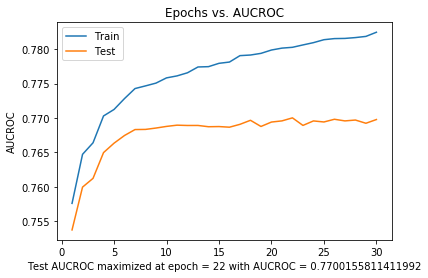

tanh 0.9 2 binary_crossentropy 0.33 200 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 11s 264us/step - loss: 0.5404 - acc: 0.7392
Epoch 2/30
43326/43326 [==============================] - 7s 163us/step - loss: 0.5058 - acc: 0.7538
Epoch 3/30
43326/43326 [==============================] - 7s 162us/step - loss: 0.4990 - acc: 0.7581
Epoch 4/30
43326/43326 [==============================] - 7s 167us/step - loss: 0.4963 - acc: 0.7602
Epoch 5/30
43326/43326 [==============================] - 7s 163us/step - loss: 0.4953 - acc: 0.7635
Epoch 6/30
43326/43326 [==============================] - 7s 162us/step - loss: 0.4936 - acc: 0.7625
Epoch 7/30
43326/43326 [==============================] - 7s 163us/step - loss: 0.4928 - acc: 0.7638
Epoch 8/30
43326/43326 [==============================] - 7s 161us/step - loss: 0.4909 - acc: 0.7657
Epoch 9/30
43326/43326 [==============================] - 7s 162us/step - loss: 0.4877 - acc: 0.7682
Epoch 10/30
43326/43326 [==============================] - 7s 164us/step - loss: 0.4891 - 

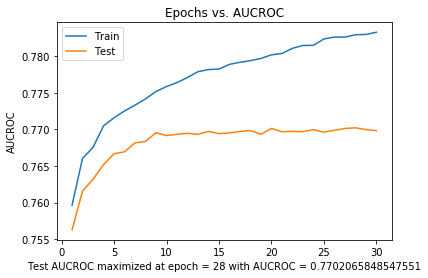

tanh 0.9 2 binary_crossentropy 0.33 200 0.2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 12s 273us/step - loss: 0.5422 - acc: 0.7366
Epoch 2/30
43326/43326 [==============================] - 7s 169us/step - loss: 0.5058 - acc: 0.7529
Epoch 3/30
43326/43326 [==============================] - 7s 168us/step - loss: 0.4980 - acc: 0.7596
Epoch 4/30
43326/43326 [==============================] - 7s 168us/step - loss: 0.4968 - acc: 0.7606
Epoch 5/30
43326/43326 [==============================] - 7s 169us/step - loss: 0.4941 - acc: 0.7601
Epoch 6/30
43326/43326 [==============================] - 7s 165us/step - loss: 0.4930 - acc: 0.7626
Epoch 7/30
43326/43326 [==============================] - 7s 162us/step - loss: 0.4923 - acc: 0.7637
Epoch 8/30
43326/43326 [==============================] - 7s 171us/step - loss: 0.4902 - acc: 0.7652
Epoch 9/30
43326/43326 [==============================] - 7s 168us/step - loss: 0.4878 - acc: 0.7683
Epoch 10/30
43326/43326 [==============================] - 7s 159us/step - loss: 0.4880 - 

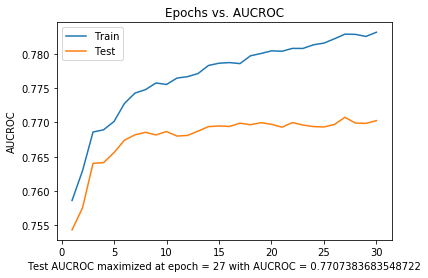

tanh 0.9 2 binary_crossentropy 0.33 200 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 12s 277us/step - loss: 0.5413 - acc: 0.7382
Epoch 2/30
43326/43326 [==============================] - 7s 163us/step - loss: 0.5057 - acc: 0.7561
Epoch 3/30
43326/43326 [==============================] - 7s 161us/step - loss: 0.4986 - acc: 0.7585
Epoch 4/30
43326/43326 [==============================] - 7s 163us/step - loss: 0.4985 - acc: 0.7599
Epoch 5/30
43326/43326 [==============================] - 7s 161us/step - loss: 0.4937 - acc: 0.7625
Epoch 6/30
43326/43326 [==============================] - 7s 164us/step - loss: 0.4939 - acc: 0.7640
Epoch 7/30
43326/43326 [==============================] - 7s 172us/step - loss: 0.4920 - acc: 0.7627
Epoch 8/30
43326/43326 [==============================] - 7s 163us/step - loss: 0.4902 - acc: 0.7654
Epoch 9/30
43326/43326 [==============================] - 7s 162us/step - loss: 0.4880 - acc: 0.7660
Epoch 10/30
43326/43326 [==============================] - 7s 163us/step - loss: 0.4869 - 

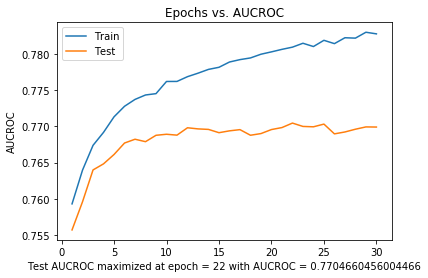

hard_sigmoid 0.7 2 binary_crossentropy 0.33 100 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 12s 277us/step - loss: 0.5286 - acc: 0.7434
Epoch 2/30
43326/43326 [==============================] - 8s 180us/step - loss: 0.4968 - acc: 0.7608
Epoch 3/30
43326/43326 [==============================] - 8s 178us/step - loss: 0.4922 - acc: 0.7664
Epoch 4/30
43326/43326 [==============================] - 8s 178us/step - loss: 0.4874 - acc: 0.7689
Epoch 5/30
43326/43326 [==============================] - 8s 179us/step - loss: 0.4852 - acc: 0.7694
Epoch 6/30
43326/43326 [==============================] - 8s 176us/step - loss: 0.4840 - acc: 0.7697
Epoch 7/30
43326/43326 [==============================] - 8s 177us/step - loss: 0.4820 - acc: 0.7719
Epoch 8/30
43326/43326 [==============================] - 8s 177us/step - loss: 0.4810 - acc: 0.7716
Epoch 9/30
43326/43326 [==============================] - 8s 177us/step - loss: 0.4793 - acc: 0.7726
Epoch 10/30
43326/43326 [==============================] - 8s 179us/step - loss: 0.4783 - 

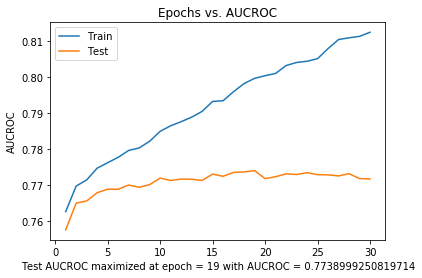

hard_sigmoid 0.7 2 binary_crossentropy 0.33 100 0.2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 24s 543us/step - loss: 0.5311 - acc: 0.7445
Epoch 2/30
43326/43326 [==============================] - 15s 348us/step - loss: 0.4977 - acc: 0.7609
Epoch 3/30
43326/43326 [==============================] - 14s 331us/step - loss: 0.4907 - acc: 0.7660
Epoch 4/30
43326/43326 [==============================] - 13s 296us/step - loss: 0.4883 - acc: 0.7655
Epoch 5/30
43326/43326 [==============================] - 14s 331us/step - loss: 0.4863 - acc: 0.7677
Epoch 6/30
43326/43326 [==============================] - 17s 383us/step - loss: 0.4853 - acc: 0.7702
Epoch 7/30
43326/43326 [==============================] - 18s 415us/step - loss: 0.4828 - acc: 0.7720
Epoch 8/30
43326/43326 [==============================] - 20s 466us/step - loss: 0.4814 - acc: 0.7731
Epoch 9/30
43326/43326 [==============================] - 14s 321us/step - loss: 0.4806 - acc: 0.7714
Epoch 10/30
43326/43326 [==============================] - 15s 347us/step - loss: 

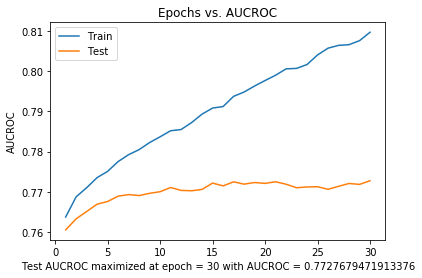

hard_sigmoid 0.7 2 binary_crossentropy 0.33 100 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 25s 567us/step - loss: 0.5269 - acc: 0.7440
Epoch 2/30
43326/43326 [==============================] - 16s 359us/step - loss: 0.4975 - acc: 0.7629
Epoch 3/30
43326/43326 [==============================] - 17s 381us/step - loss: 0.4920 - acc: 0.7657
Epoch 4/30
43326/43326 [==============================] - 15s 339us/step - loss: 0.4881 - acc: 0.7670
Epoch 5/30
43326/43326 [==============================] - 13s 311us/step - loss: 0.4863 - acc: 0.7688
Epoch 6/30
43326/43326 [==============================] - 15s 335us/step - loss: 0.4857 - acc: 0.7682
Epoch 7/30
43326/43326 [==============================] - 13s 310us/step - loss: 0.4827 - acc: 0.7721
Epoch 8/30
43326/43326 [==============================] - 13s 303us/step - loss: 0.4806 - acc: 0.7716
Epoch 9/30
43326/43326 [==============================] - 14s 327us/step - loss: 0.4807 - acc: 0.7719
Epoch 10/30
43326/43326 [==============================] - 28s 640us/step - loss: 

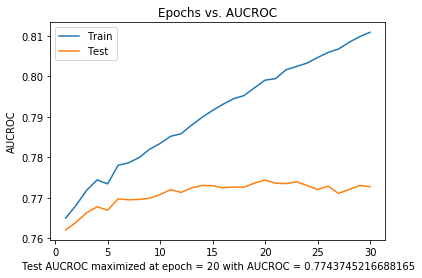

hard_sigmoid 0.7 2 binary_crossentropy 0.33 150 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 29s 669us/step - loss: 0.5311 - acc: 0.7428
Epoch 2/30
43326/43326 [==============================] - 18s 406us/step - loss: 0.4967 - acc: 0.7638
Epoch 3/30
43326/43326 [==============================] - 18s 425us/step - loss: 0.4924 - acc: 0.7637
Epoch 4/30
43326/43326 [==============================] - 16s 366us/step - loss: 0.4892 - acc: 0.7679
Epoch 5/30
43326/43326 [==============================] - 14s 333us/step - loss: 0.4863 - acc: 0.7694
Epoch 6/30
43326/43326 [==============================] - 15s 337us/step - loss: 0.4854 - acc: 0.7685
Epoch 7/30
43326/43326 [==============================] - 15s 349us/step - loss: 0.4834 - acc: 0.7707
Epoch 8/30
43326/43326 [==============================] - 20s 462us/step - loss: 0.4822 - acc: 0.7718
Epoch 9/30
43326/43326 [==============================] - 23s 530us/step - loss: 0.4810 - acc: 0.7722
Epoch 10/30
43326/43326 [==============================] - 15s 351us/step - loss: 

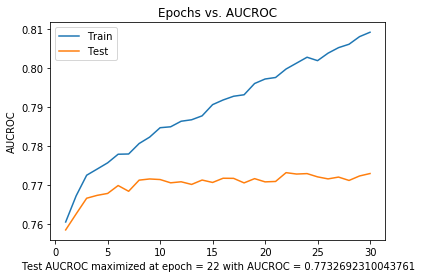

hard_sigmoid 0.7 2 binary_crossentropy 0.33 150 0.2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 32s 740us/step - loss: 0.5299 - acc: 0.7452
Epoch 2/30
43326/43326 [==============================] - 18s 421us/step - loss: 0.4987 - acc: 0.7595
Epoch 3/30
43326/43326 [==============================] - 16s 379us/step - loss: 0.4915 - acc: 0.7648
Epoch 4/30
43326/43326 [==============================] - 22s 519us/step - loss: 0.4899 - acc: 0.7675
Epoch 5/30
43326/43326 [==============================] - 19s 445us/step - loss: 0.4869 - acc: 0.7692
Epoch 6/30
43326/43326 [==============================] - 18s 417us/step - loss: 0.4841 - acc: 0.7699
Epoch 7/30
43326/43326 [==============================] - 17s 396us/step - loss: 0.4837 - acc: 0.7700
Epoch 8/30
43326/43326 [==============================] - 17s 391us/step - loss: 0.4827 - acc: 0.7717
Epoch 9/30
43326/43326 [==============================] - 17s 381us/step - loss: 0.4807 - acc: 0.7731
Epoch 10/30
43326/43326 [==============================] - 19s 432us/step - loss: 

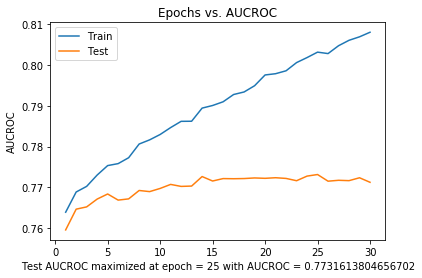

hard_sigmoid 0.7 2 binary_crossentropy 0.33 150 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 30s 691us/step - loss: 0.5331 - acc: 0.7437
Epoch 2/30
43326/43326 [==============================] - 14s 334us/step - loss: 0.4970 - acc: 0.7613
Epoch 3/30
43326/43326 [==============================] - 16s 366us/step - loss: 0.4910 - acc: 0.7666
Epoch 4/30
43326/43326 [==============================] - 16s 370us/step - loss: 0.4889 - acc: 0.7662
Epoch 5/30
43326/43326 [==============================] - 9s 217us/step - loss: 0.4879 - acc: 0.7670
Epoch 6/30
43326/43326 [==============================] - 2344s 54ms/step - loss: 0.4865 - acc: 0.7670
Epoch 7/30
43326/43326 [==============================] - 30s 684us/step - loss: 0.4845 - acc: 0.7695
Epoch 8/30
43326/43326 [==============================] - 16s 360us/step - loss: 0.4822 - acc: 0.7723
Epoch 9/30
43326/43326 [==============================] - 8s 182us/step - loss: 0.4822 - acc: 0.7729
Epoch 10/30
43326/43326 [==============================] - 8s 195us/step - loss: 0.

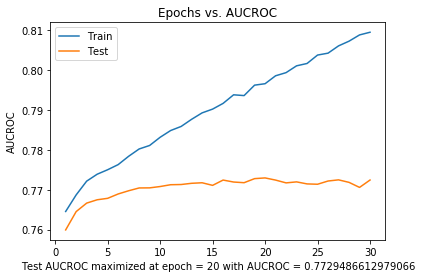

hard_sigmoid 0.7 2 binary_crossentropy 0.33 200 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/30
43326/43326 [==============================] - 14s 323us/step - loss: 0.5331 - acc: 0.7415
Epoch 2/30
43326/43326 [==============================] - 8s 178us/step - loss: 0.4968 - acc: 0.7623
Epoch 3/30
43326/43326 [==============================] - 8s 189us/step - loss: 0.4920 - acc: 0.7645
Epoch 4/30
43326/43326 [==============================] - 8s 178us/step - loss: 0.4883 - acc: 0.7682
Epoch 5/30
43326/43326 [==============================] - 8s 179us/step - loss: 0.4860 - acc: 0.7682
Epoch 6/30
43326/43326 [==============================] - 8s 175us/step - loss: 0.4863 - acc: 0.7701
Epoch 7/30
43326/43326 [==============================] - 8s 184us/step - loss: 0.4830 - acc: 0.7702
Epoch 8/30
43326/43326 [==============================] - 8s 182us/step - loss: 0.4808 - acc: 0.7719


In [ ]:
for activation in activations:
    for dropout in dropouts:
        for num_total_layer in num_total_layers:
            for loss in losses:
                for val_size in val_sizes:
                    for last_layer_size in last_layer_sizes:
                        for last_layer_drop_size in last_layer_drop_sizes:
                            x_train, x_test, y_train, y_test = get_correct_split(val_size)
                            print(activation, dropout, num_total_layer, loss, val_size, last_layer_size, last_layer_drop_size)
                            model = create_model(activation, dropout, num_total_layer, last_layer_size, last_layer_drop_size)
                            train_model(model, activation, dropout, num_total_layer, loss, val_size, last_layer_size, last_layer_drop_size, x_train, y_train, x_test, y_test)
#                             model.summary()

In [ ]:
# def generate_csv(model, x_data, name):
#     ids = [i for i, _ in enumerate(x_data)]
#     ids = np.array(ids)
    
#     predictions = model.predict(x_data).flatten()
    
#     df = pd.DataFrame()
#     df['id'] = ids
#     df['target'] = predictions
#     df.to_csv(name + ".csv", index=False)

# #     print df.head()

# x_actual_test = np.load("data/x_test.npy")

# generate_csv(model, x_actual_test, "submissions/third_test")